In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sentiment analysis
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

# t-test
import pingouin

In [2]:
opiates = pd.read_csv('SubredditDatasets/opiates_cleaned.csv', parse_dates=['date'])
recovery = pd.read_csv('SubredditDatasets/recovery_cleaned.csv', parse_dates=['date'])

# Building Sentiment Analysis Model

In [3]:
# import training dataset
reddit = pd.read_csv('TrainingDatasets/Labeled_Reddit_Data.csv')
reddit = reddit.dropna().reset_index(drop=True)
reddit.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [4]:
reddit.category.value_counts()

 1    15830
 0    13042
-1     8277
Name: category, dtype: int64

In [5]:
# build sentiment analyzer
X = reddit['clean_comment']
y = reddit['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [6]:
tfidf = TfidfVectorizer()
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

In [7]:
svc = LinearSVC(random_state=1, max_iter=15000)
svc.fit(tfidf_train, y_train)

y_pred = svc.predict(tfidf_test)

              precision    recall  f1-score   support

          -1       0.89      0.76      0.82      1644
           0       0.90      0.97      0.93      2639
           1       0.90      0.91      0.91      3147

    accuracy                           0.90      7430
   macro avg       0.90      0.88      0.89      7430
weighted avg       0.90      0.90      0.90      7430



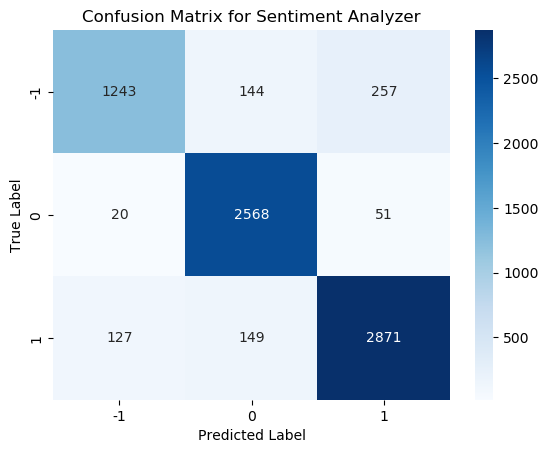

In [8]:
print(classification_report(y_test, y_pred))

ax = sns.heatmap(confusion_matrix(y_test, y_pred), 
                 cmap='Blues', 
                 annot=True, 
                 fmt='g', 
                 xticklabels=[-1, 0, 1], 
                 yticklabels=[-1, 0, 1])
ax.set(ylabel="True Label", xlabel="Predicted Label")
plt.title("Confusion Matrix for Sentiment Analyzer")
plt.show()

# Sentiment Analysis

In [9]:
# use model to label opiates posts
corpus_opiates = []
for i in opiates.index:
    corpus_opiates.append(opiates['cleaned_text'][i])

X_opiates = tfidf.transform(corpus_opiates)
y_opiates = svc.predict(X_opiates)

opiates['label'] = y_opiates
opiates.label.value_counts()

 1    19563
-1     8623
 0     3550
Name: label, dtype: int64

In [10]:
# use model to label recovery posts
corpus_recovery = []
for i in recovery.index:
    corpus_recovery.append(recovery['cleaned_text'][i])

X_recovery = tfidf.transform(corpus_recovery)
y_recovery = svc.predict(X_recovery)

recovery['label'] = y_recovery
recovery.label.value_counts()

 1    6962
-1    2482
 0     744
Name: label, dtype: int64

## Calculate the % of posts that are pos/neg for each subreddit

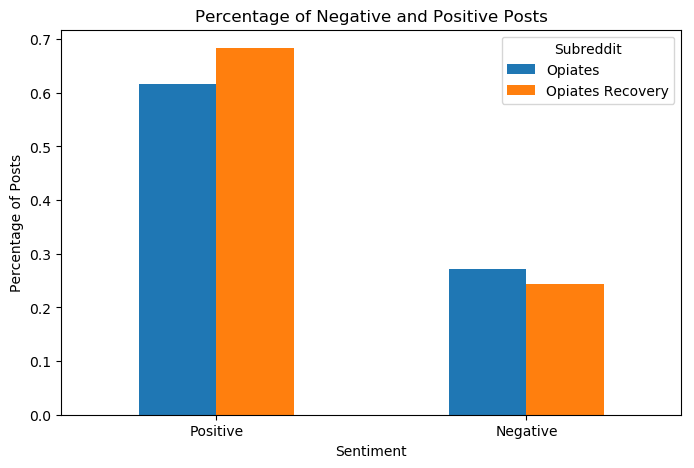

In [11]:
# calculate the percent of posts that are positive/negative for each subreddit
compare = pd.DataFrame()
compare['Sentiment'] = ['Positive', 'Negative']
compare['Opiates'] = [len(opiates[opiates['label']==1])/len(opiates['label']), 
                      len(opiates[opiates['label']==-1])/len(opiates['label'])]
compare['Opiates Recovery'] = [len(recovery[recovery['label']==1])/len(recovery['label']),
                               len(recovery[recovery['label']==-1])/len(recovery['label'])]
compare = compare.set_index('Sentiment')

compare.plot(kind='bar', figsize=(8,5)).legend(title='Subreddit')
plt.xticks(rotation=0)
plt.ylabel('Percentage of Posts')
plt.yticks(np.arange(0, 0.8, step=0.1))
plt.title('Percentage of Negative and Positive Posts')
plt.show()

In [12]:
compare

,Opiates,Opiates Recovery
Sentiment,,
Positive,0.616429,0.683353
Negative,0.271710,0.243620


## Calculate % of posts per month that are pos/neg

In [13]:
# calculate percent of posts per month that are positive/negative
def calc_sentiment_percentage(df):
    tmp = df[['label', 'date']].copy()
    sentiment_df = pd.DataFrame()

    sentiment_df['date'] = pd.DataFrame(tmp.groupby(tmp['date'].dt.to_period('M')).size()).reset_index()['date']
    sentiment_df['# of Posts'] = pd.DataFrame(tmp.groupby(tmp['date'].dt.to_period('M')).size()).reset_index()[0]
    sentiment_df['# of Neg Posts'] = pd.DataFrame(tmp[tmp['label']==-1].groupby(tmp['date'].dt.to_period('M')).size()).reset_index()[0]
    sentiment_df['% of Neg Posts'] = round(sentiment_df['# of Neg Posts']/sentiment_df['# of Posts'], 2)
    sentiment_df['# of Pos Posts'] = pd.DataFrame(tmp[tmp['label']==1].groupby(tmp['date'].dt.to_period('M')).size()).reset_index()[0]
    sentiment_df['% of Pos Posts'] = round(sentiment_df['# of Pos Posts']/sentiment_df['# of Posts'], 2)
    
    return sentiment_df.set_index('date')

In [14]:
opiates_sentiment_perc = calc_sentiment_percentage(opiates)
recovery_sentiment_perc = calc_sentiment_percentage(recovery)

In [22]:
opiates_sentiment_perc.reset_index().to_csv('SubredditDatasets/opiates_sentiment_perc.csv', index=False)
recovery_sentiment_perc.reset_index().to_csv('SubredditDatasets/recovery_sentiment_perc.csv', index=False)

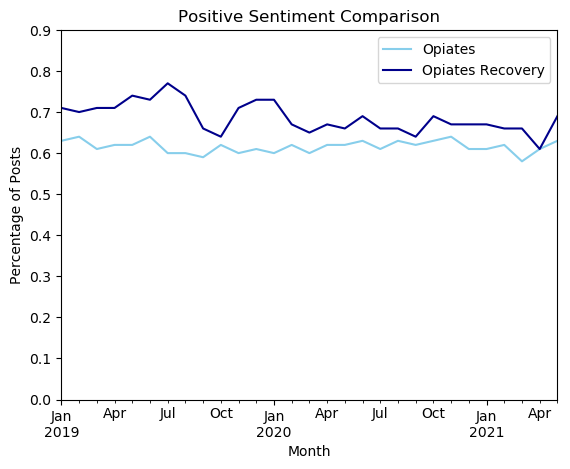

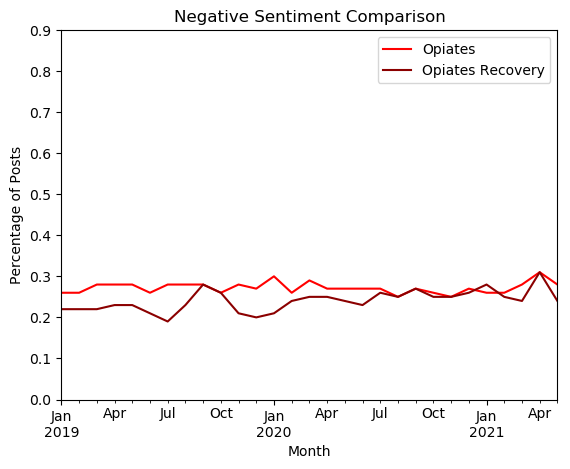

In [16]:
cols = ['% of Pos Posts', '% of Neg Posts']
for col in cols:
    if 'Pos ' in col:
        color1, color2, sent = "skyblue", "darkblue", "Positive"
    else:
        color1, color2, sent = "red", "darkred", "Negative"
    opiates_sentiment_perc[col].plot(label="Opiates", color=color1, linestyle="-")
    recovery_sentiment_perc[col].plot(label="Opiates Recovery", color=color2, linestyle="-")
    plt.xlabel("Month")
    plt.ylabel("Percentage of Posts")
    plt.yticks(np.arange(0, 1, step=0.1))
    plt.title(sent+" Sentiment Comparison")
    plt.legend()
    plt.show()

## T-test

In [17]:
pos_t = pingouin.ttest(opiates_sentiment_perc['% of Pos Posts'], recovery_sentiment_perc['% of Pos Posts'])['p-val']
neg_t = pingouin.ttest(opiates_sentiment_perc['% of Neg Posts'], recovery_sentiment_perc['% of Neg Posts'])['p-val']
print('P-val for positive sentiment:', pos_t)
print('\nP-val for negative sentiment:', neg_t)

P-val for positive sentiment: T-test    2.484951e-13
Name: p-val, dtype: float64

P-val for negative sentiment: T-test    4.365987e-07
Name: p-val, dtype: float64


In [18]:
opiates_covid = opiates_sentiment_perc.reset_index().copy()
opiates_pre_covid = opiates_covid[opiates_covid['date']<'2020-03']
opiates_post_covid = opiates_covid[opiates_covid['date']>='2020-03']

recovery_covid = recovery_sentiment_perc.reset_index().copy()
recovery_pre_covid = recovery_covid[recovery_covid['date']<'2020-03']
recovery_post_covid = recovery_covid[recovery_covid['date']>='2020-03']

In [19]:
pos_pre = pingouin.ttest(opiates_pre_covid['% of Pos Posts'], recovery_pre_covid['% of Pos Posts'])['p-val']
pos_post = pingouin.ttest(opiates_post_covid['% of Pos Posts'], recovery_post_covid['% of Pos Posts'])['p-val']
print('P-val for positive sentiment comparison pre covid:', pos_pre)
print("\nP-val for positive sentiment comparison post covid:", pos_post)

P-val for positive sentiment comparison pre covid: T-test    6.386500e-10
Name: p-val, dtype: float64

P-val for positive sentiment comparison post covid: T-test    1.246734e-07
Name: p-val, dtype: float64


In [20]:
neg_pre = pingouin.ttest(opiates_pre_covid['% of Neg Posts'], recovery_pre_covid['% of Neg Posts'])['p-val']
neg_post = pingouin.ttest(opiates_post_covid['% of Neg Posts'], recovery_post_covid['% of Neg Posts'])['p-val']
print("P-val for negative sentiment comparison pre covid:", neg_pre)
print("\nP-val for negative sentiment comparison post covid:", neg_post)

P-val for negative sentiment comparison pre covid: T-test    2.648492e-07
Name: p-val, dtype: float64

P-val for negative sentiment comparison post covid: T-test    0.02399
Name: p-val, dtype: float64
